In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from UnifiedMomentumModel.Momentum import UnifiedMomentum

# Analytical Models

## Define Analytical Models

In [2]:
def classical(ctp):  # return Cp for classical momentum theory
    a = ctp / (4 + ctp)
    return 4 * a * (1 - a)**2

In [3]:
def johlas(ctp, sa, pa):  # return Cp for classical momentum theory adjusted by coefficents in Johlas 2020
    cp = classical(ctp)
    x_disp = (1 + (3 * (sa**2)) / 2)
    theta_disp = np.mean([np.cos(np.deg2rad(pa) * np.sin(x))**3 for x in np.linspace(0, 2 * np.pi, 250)])
    return cp * x_disp * theta_disp  # coefficents from turbine movement

In [4]:
def umm(ctp, sf, sa, pa):
    model = UnifiedMomentum()
    sf_rad = np.deg2rad(sf)
    sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
    sa_vals = (sa * sin_vals) + 1
    sa_vals_cubed = sa_vals**3
    pa_vals = np.deg2rad(pa) * sin_vals
    umm_vals = np.array([np.mean(sa_vals_cubed * model(Ctprime = c, yaw = 0.0, tilt = pa_vals).Cp) for c in np.atleast_1d(ctp)])
    return umm_vals

## Plot Analytical Models

In [5]:
palette =['tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:red']

### For this initial exploration, we will use $f = 1.0$ and $A_S = 0.5$ & $A_P = 5^\circ$. 

In [6]:
ctp_list = np.linspace(0.01, 10, num = 100)

In [7]:
def fix_plot_legend(ax, xOffset = 1.85, title = ""):
    leg = ax.legend(title = title)
    bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
    return

In [8]:
def plot_mean_cp_models(ctp_list, f, sa, pa, palette = palette):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (10, 4), dpi = 300)
    fig.suptitle("Mean $C_P$ vs $C_T^'$", size = 16, y = 1.04)
    ax0.set_title(f"Surging ($f = {f}$, A = ${sa}$)", size = 14, y = 1.04)
    ax1.set_title(f"Pitching ($f = {f}$, A = ${pa}^\circ$)", size = 14, y = 1.04)
    ax0.set_xlabel('$C_T^\'$', size = 15)
    ax1.set_xlabel('$C_T^\'$', size = 15)
    ax0.set_ylabel('Mean $C_P$', size = 15)
    ax1.set_ylabel('Mean $C_P$', size = 15)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax0.set_ylim(0, 1)
    linewidth = 3.5

    classical_cp = classical(ctp_list)
    # plot surging
    johlas_cp_surge = johlas(ctp_list, sa, 0)
    umm_cp_surge = umm(ctp_list, f, sa, 0)
    sns.lineplot(ax = ax0, x = ctp_list, y = classical_cp, color=palette[0], label = "Classical", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = johlas_cp_surge, color=palette[1], label = "Johlas", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = umm_cp_surge, color=palette[2], label = "Quasi-Steady UMM", linewidth = linewidth)

    # plot pitching
    johlas_cp_pitch = johlas(ctp_list, 0, pa)
    umm_cp_pitch = umm(ctp_list, f, 0, pa)
    sns.lineplot(ax = ax1, x = ctp_list, y = classical_cp, color=palette[0], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = johlas_cp_pitch, color=palette[1], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = umm_cp_pitch, color=palette[2], linewidth = linewidth, legend=False)

    # adjust plot legend and spacing
    fix_plot_legend(ax0)
    fig.subplots_adjust(wspace=0.25)
    return fig, (ax0, ax1)


/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value encountered in divide
  sin_a = np.where(tilt == 0, 0, -(np.sin(tilt) * np.cos(yaw)) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value 

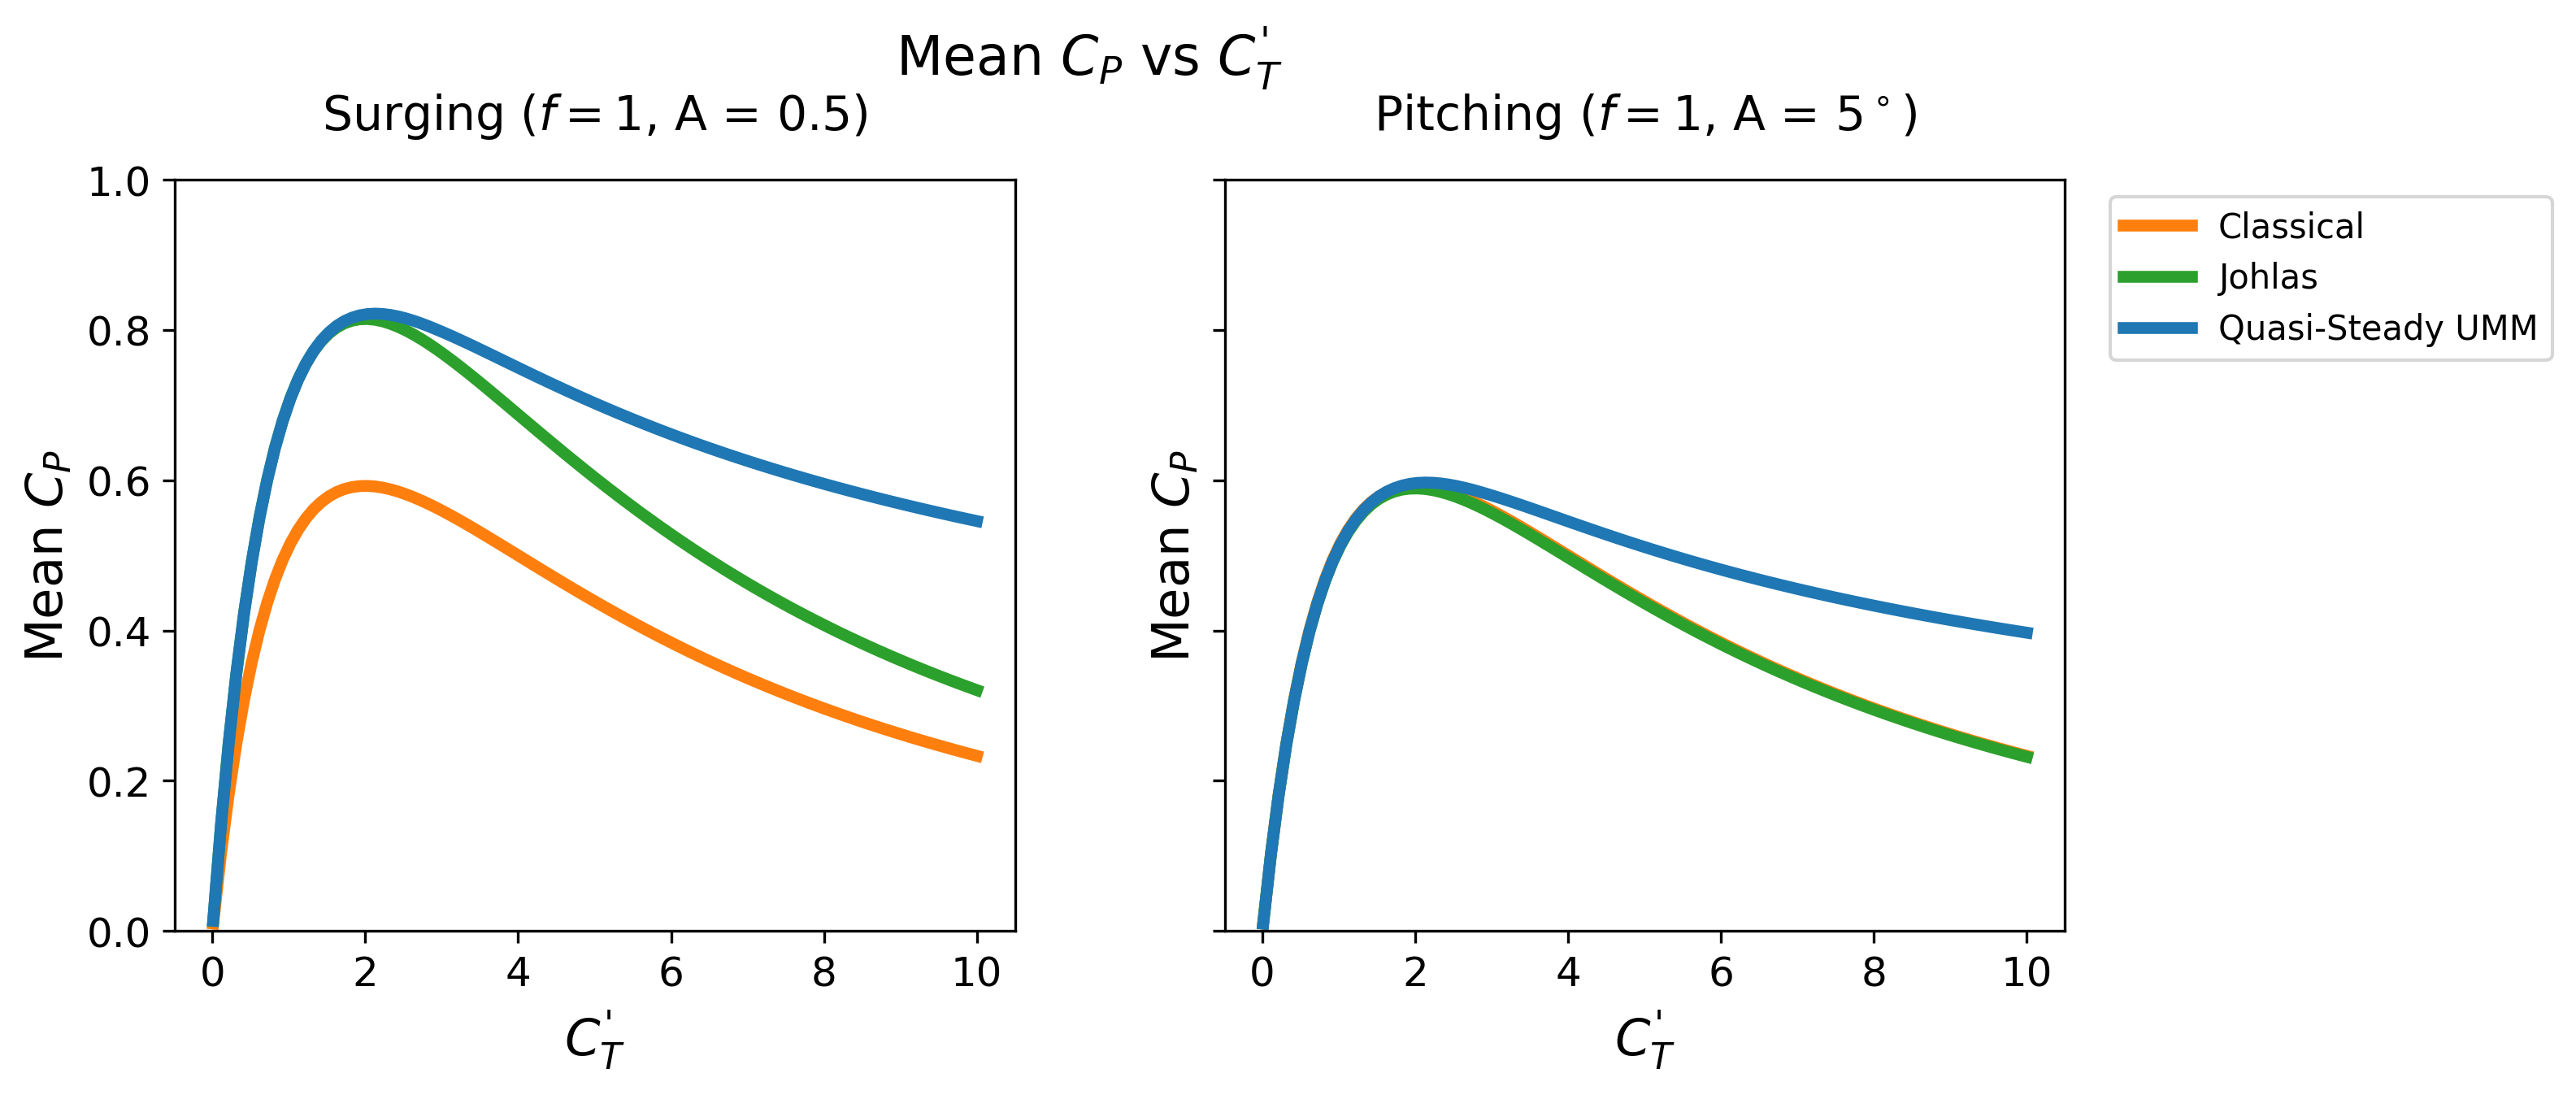

In [9]:
f, sa, pa = 1, 0.5, 5
plot_mean_cp_models(ctp_list, f, sa, pa);

# Analyze LES Data

In [10]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

df = pd.read_csv("/Users/sky/src/HowlandLab/data/expanded_moving_analysis_july_20.csv")
df = df.dropna()

In [11]:
df

,Unnamed: 0,marker,nx,ny,filter,filterFactor,useCorrection,CT_prime,turbulence,surge_freq,...,variance_Cp,std_CT,std_an,std_Cp,skewness_CT,skewness_an,skewness_Cp,kurtosis_CT,kurtosis_an,kurtosis_Cp
0,0,o,64.0,32.0,0.589831,1.000,True,1.0,False,0.0,...,3.197882e-12,1.472572e-06,9.108791e-07,1.785475e-06,3.114115,-3.114112,3.114117,9.390863,9.390842,9.390885
1,1,o,128.0,64.0,0.294915,1.000,True,1.0,False,0.0,...,7.861220e-12,2.282117e-06,1.394218e-06,2.801602e-06,-0.121881,0.121894,-0.121868,3.161778,3.161781,3.161775
2,2,o,256.0,128.0,0.147458,1.000,True,1.0,False,0.0,...,6.806981e-13,6.849901e-07,4.266991e-07,8.247230e-07,-0.367102,0.367104,-0.367100,0.398371,0.398372,0.398369
3,3,o,64.0,32.0,0.080000,0.136,True,1.0,False,0.0,...,1.359172e-11,2.926576e-06,1.745104e-06,3.680949e-06,2.864592,-2.864584,2.864601,8.871645,8.871581,8.871710
4,4,o,128.0,64.0,0.080000,0.271,True,1.0,False,0.0,...,3.867314e-10,1.578250e-05,9.507068e-06,1.965017e-05,-0.071558,0.071595,-0.071521,0.155124,0.155125,0.155123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,190,^,256.0,128.0,0.221187,1.500,True,1.0,False,0.5,...,6.345684e-05,6.641187e-03,4.153248e-03,7.964748e-03,0.006338,-0.002438,0.010237,-1.499479,-1.499514,-1.499414
191,191,^,256.0,128.0,0.221187,1.500,True,1.0,False,1.0,...,2.238699e-07,3.926474e-04,2.444196e-04,4.730758e-04,0.007293,-0.007065,0.007521,-1.499740,-1.499744,-1.499736
192,192,^,256.0,128.0,0.221187,1.500,True,1.0,False,1.0,...,3.318400e-05,4.794328e-03,2.993114e-03,5.759665e-03,-0.001373,0.004175,0.001430,-1.500068,-1.500049,-1.500073
193,193,^,256.0,128.0,0.221187,1.500,True,1.0,False,1.0,...,8.953528e-05,7.891693e-03,4.937215e-03,9.460845e-03,-0.004829,0.009457,-0.000202,-1.500593,-1.500513,-1.500633


In [12]:
df = df.dropna()
df['Movement'] = df.apply(lambda row: ("Stationary" if row.marker == "o" else ("Surging" if row.marker == "s" else "Pitching")), axis = 1)
df = df[df.nx == 256]  # only keep 256 x 128 x 128 simulations
df = df[df.filterFactor == 1.5]
df = df[df.useCorrection]
df = df[df.surge_freq < 1.5]

cols_to_keep = ["Movement", "nx", "filterFactor", "filterFactor", "useCorrection", "turbulence", "CT_prime", "surge_freq", "surge_amplitude", "pitch_amplitude"]
df = df.drop_duplicates(subset = cols_to_keep, keep = 'last')

In [13]:
max_motion_df = df[df["surge_freq"] == 1]
max_motion_df = max_motion_df[(max_motion_df["surge_amplitude"] == 0.5) | (max_motion_df["pitch_amplitude"] == 5)]

## Plot Mean $C_P$ LES Data for $f = 1$, $A_s = 0.5$, and $A_p = 5^\circ$ over $C_T'$ Values

/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value encountered in divide
  sin_a = np.where(tilt == 0, 0, -(np.sin(tilt) * np.cos(yaw)) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value 

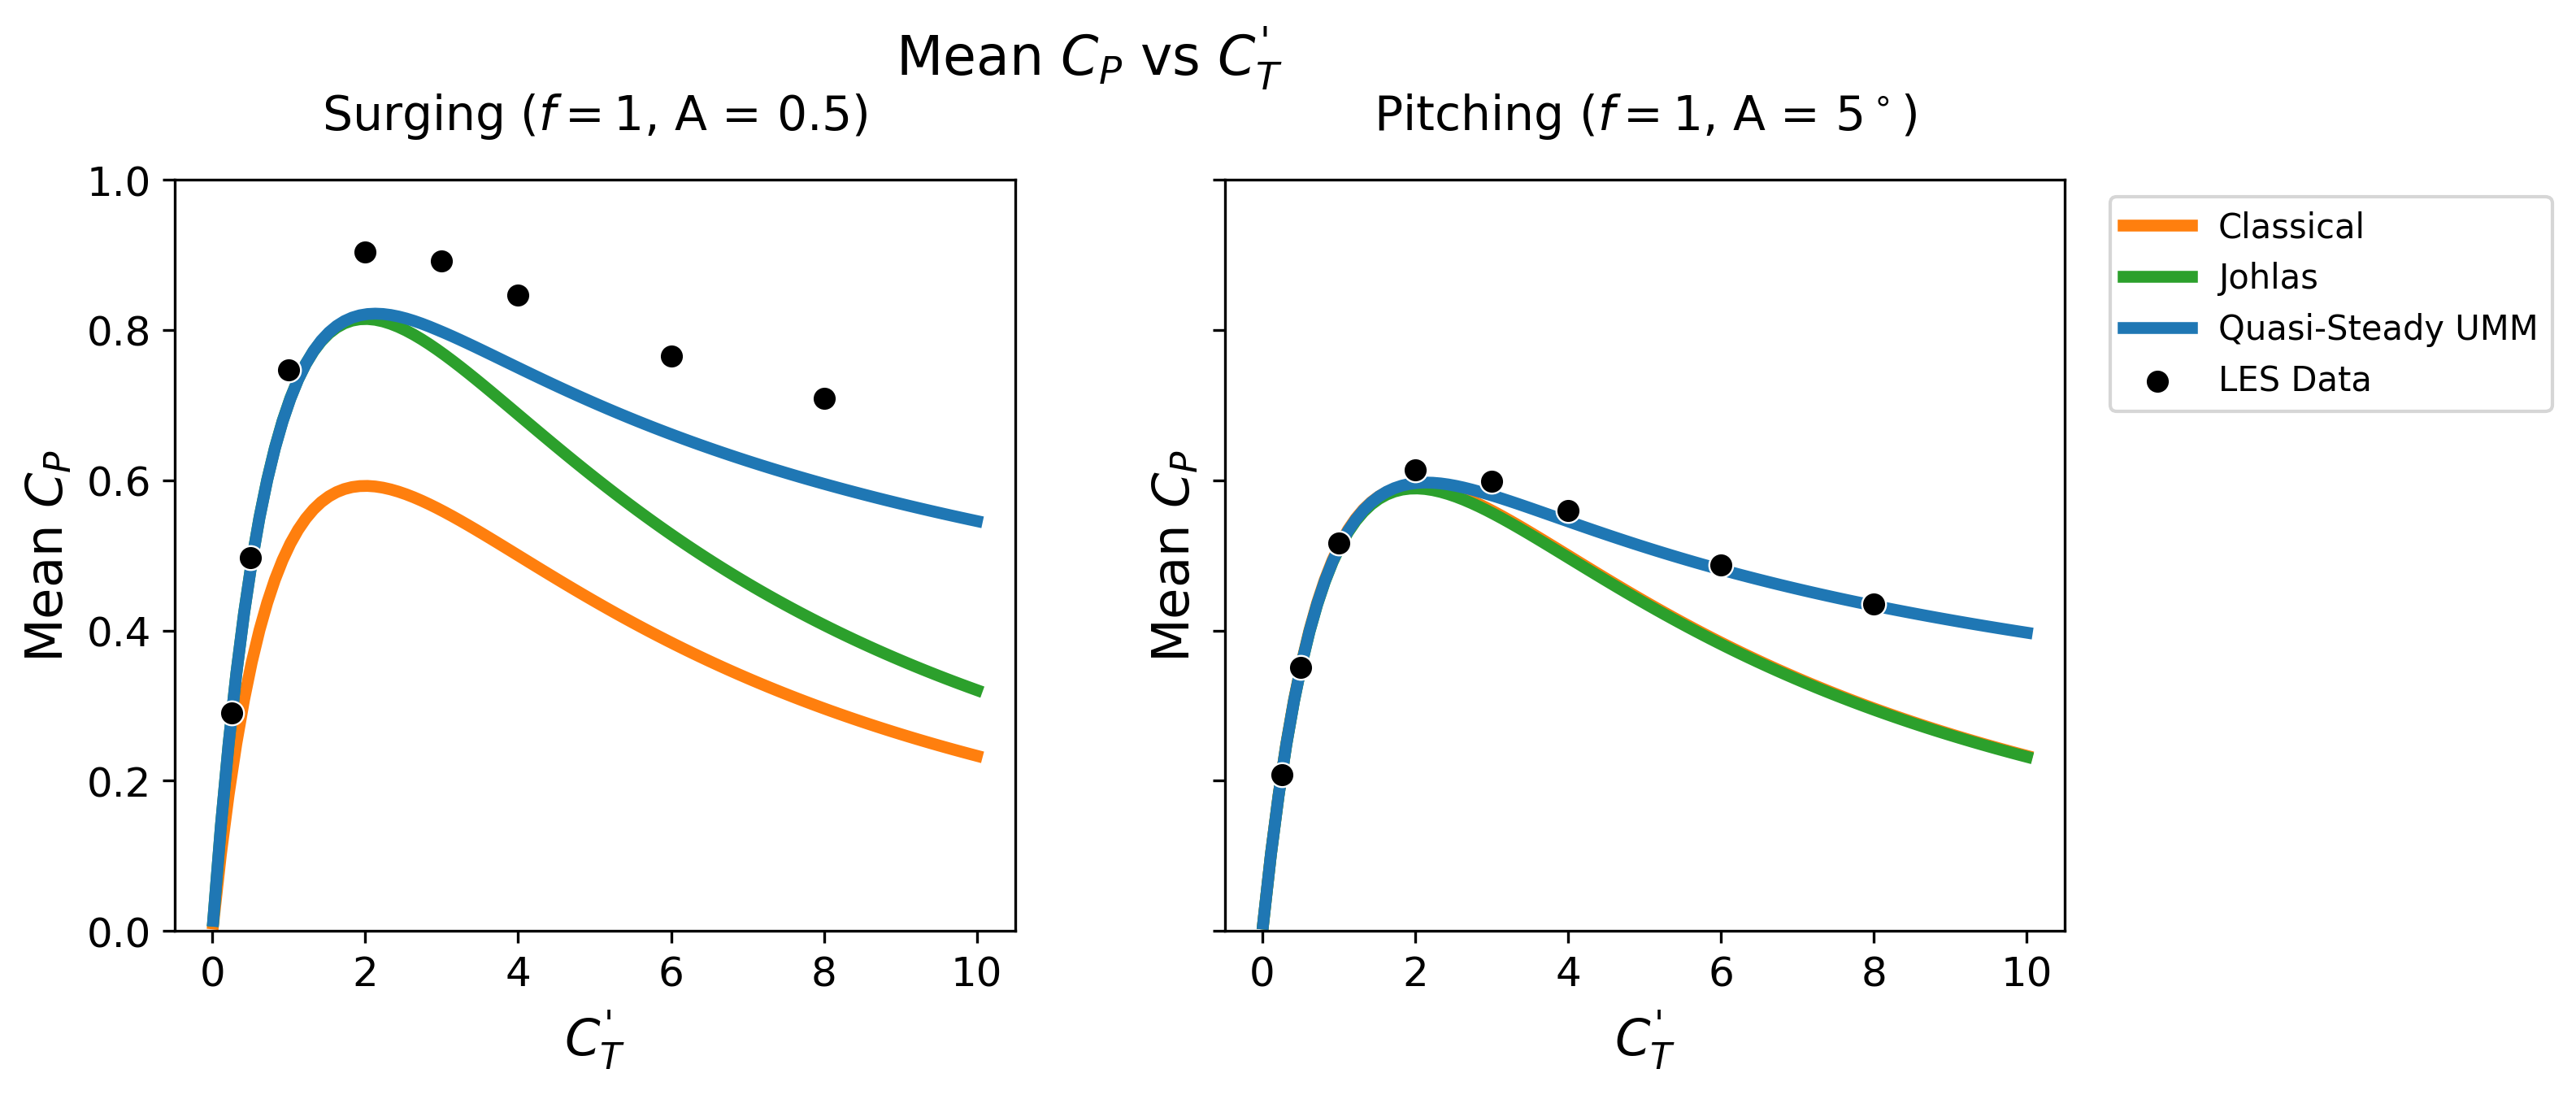

In [14]:
fig, (ax0, ax1) = plot_mean_cp_models(ctp_list, f, sa, pa);
surging_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Surging"]
sns.scatterplot(ax  = ax0, data = surging_max_motion_df, x = "CT_prime", y = "mean_Cp", color = "k", zorder = 5, s=50, label = "LES Data")
pitching_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Pitching"]
sns.scatterplot(ax = ax1, data = pitching_max_motion_df, x = "CT_prime", y = "mean_Cp", color = "k", zorder = 5, s=50, legend = False)
fix_plot_legend(ax0)

## Plot Mean $C_P$ from UMM for $C_T' = 1$ and $C_T' = 4$ for a range of $f$ and $A$

In [15]:
df["umm"] = df.apply((lambda row: umm(row.CT_prime, row.surge_freq, row.surge_amplitude, row.pitch_amplitude)[0]), axis = 1)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/3318810174.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/3318810174.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/FixedPointIteration.py:56: RuntimeWarning: All-NaN slice encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/1655727788.py:14: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/1655727788.py:17: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)


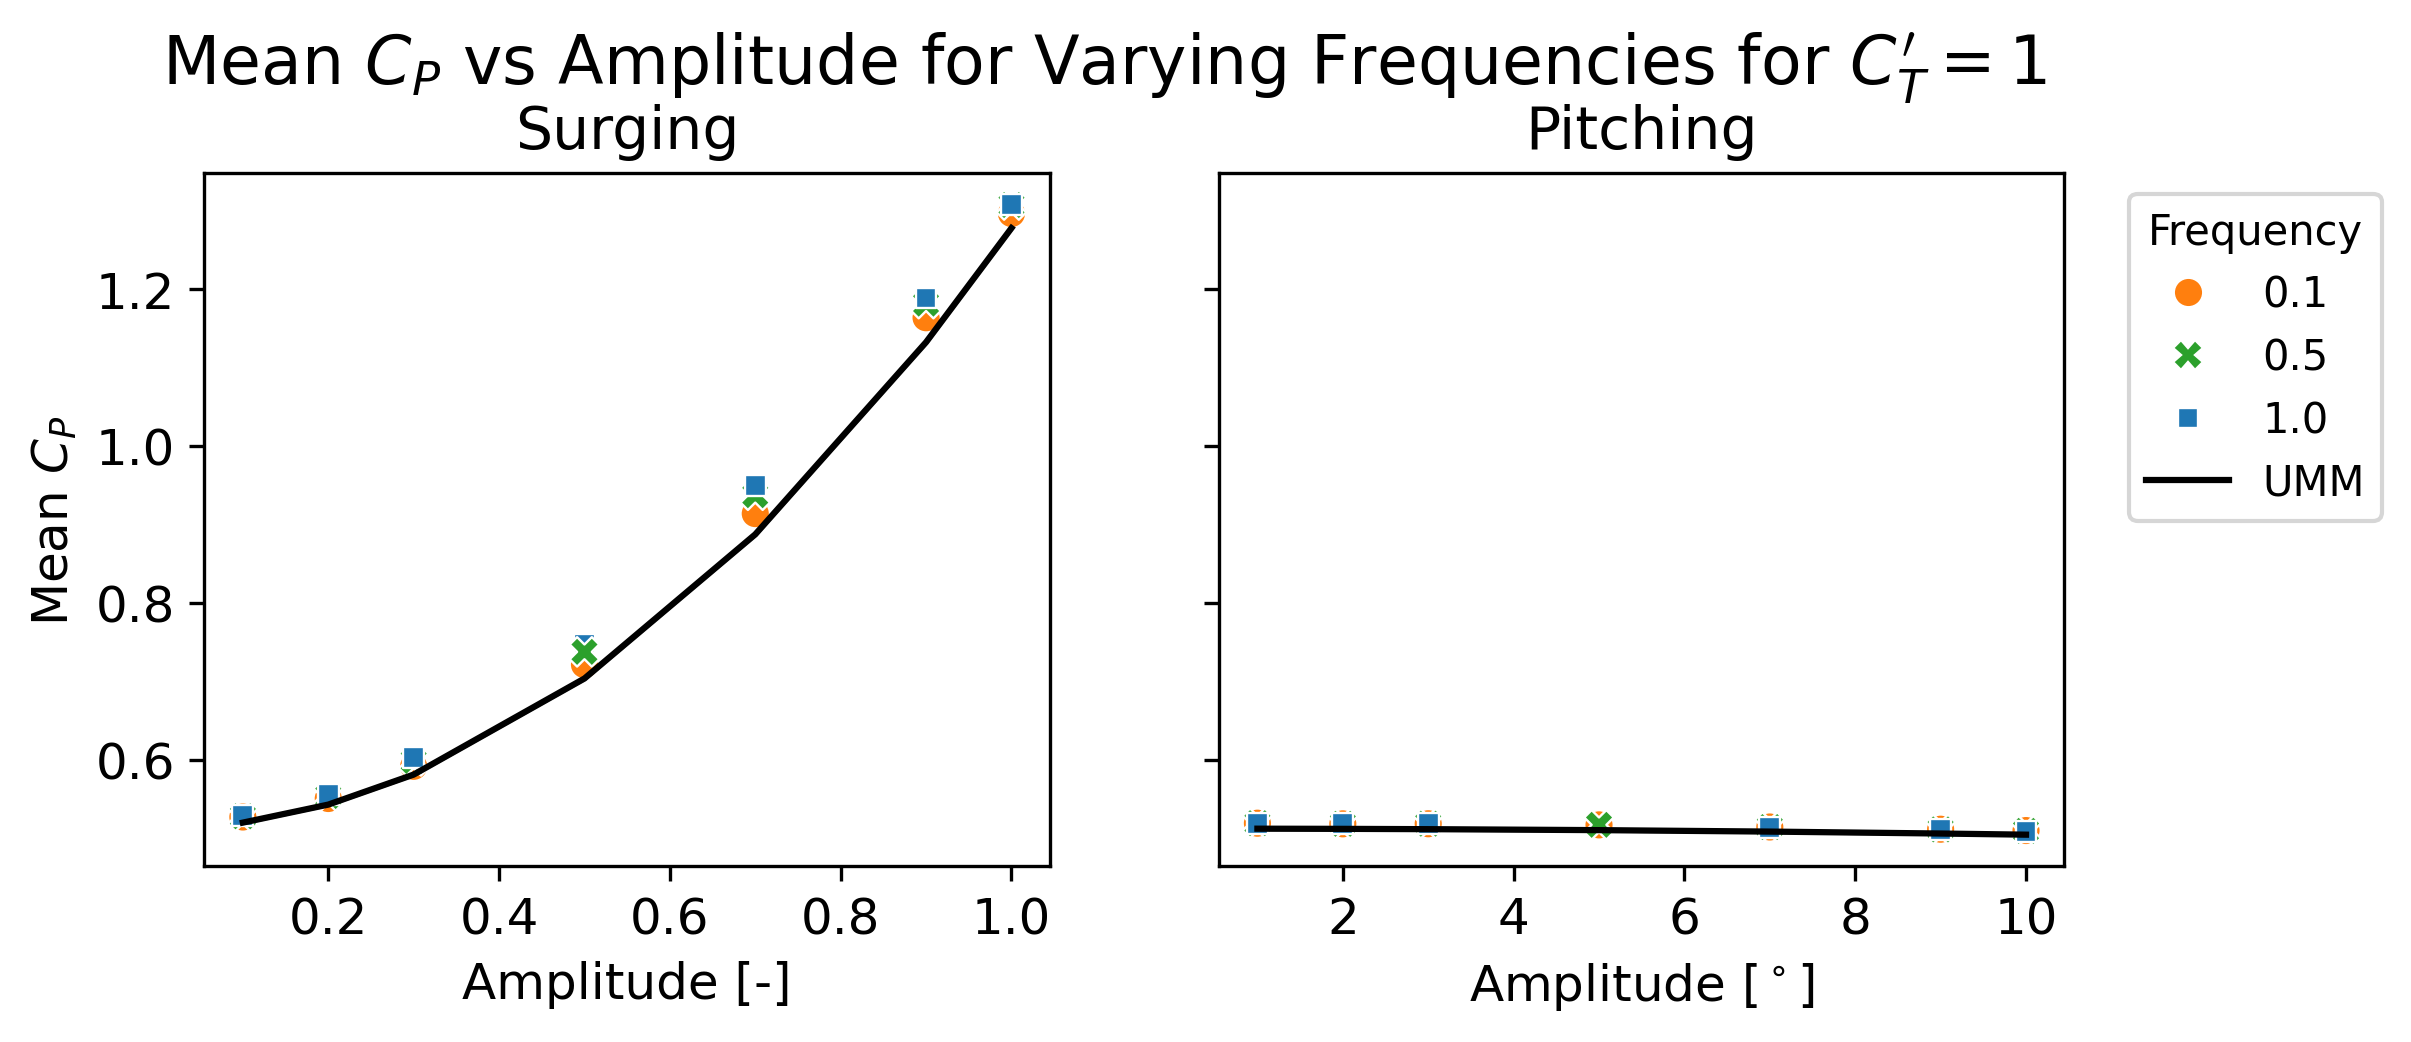

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (8, 3), dpi = 300)
fig.suptitle("Mean $C_P$ vs Amplitude for Varying Frequencies for $C_T' = 1$", size = 16, y = 1.04)
ax0.set_title("Surging", size = 14)
ax1.set_title("Pitching", size = 14)
ax0.set_xlabel('Amplitude [-]', size = 12)
ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
ax0.set_ylabel('Mean $C_P$', size = 12)
ax1.set_ylabel(' ', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df["Movement"] == "Surging") & (df["CT_prime"] == 1)]
ax1_data = df[(df["Movement"] == "Pitching") & (df["CT_prime"] == 1)]
sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
sns.lineplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "umm", color = "k", label = "UMM")

sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)
sns.lineplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "umm", color = "k")

fix_plot_legend(ax0, xOffset = 1.6, title = "Frequency")
fig.subplots_adjust(hspace = 0.5)

## Plot % Difference of Mean $C_P$ from UMM for $C_T' = 1$ and $C_T' = 4$ for a range of $f$ and $A$

In [17]:
df["percent_diff_umm"] = df.apply((lambda row: 100 * (row.umm - row.mean_Cp) / row.mean_Cp), axis = 1)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/593395375.py:14: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/593395375.py:15: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)


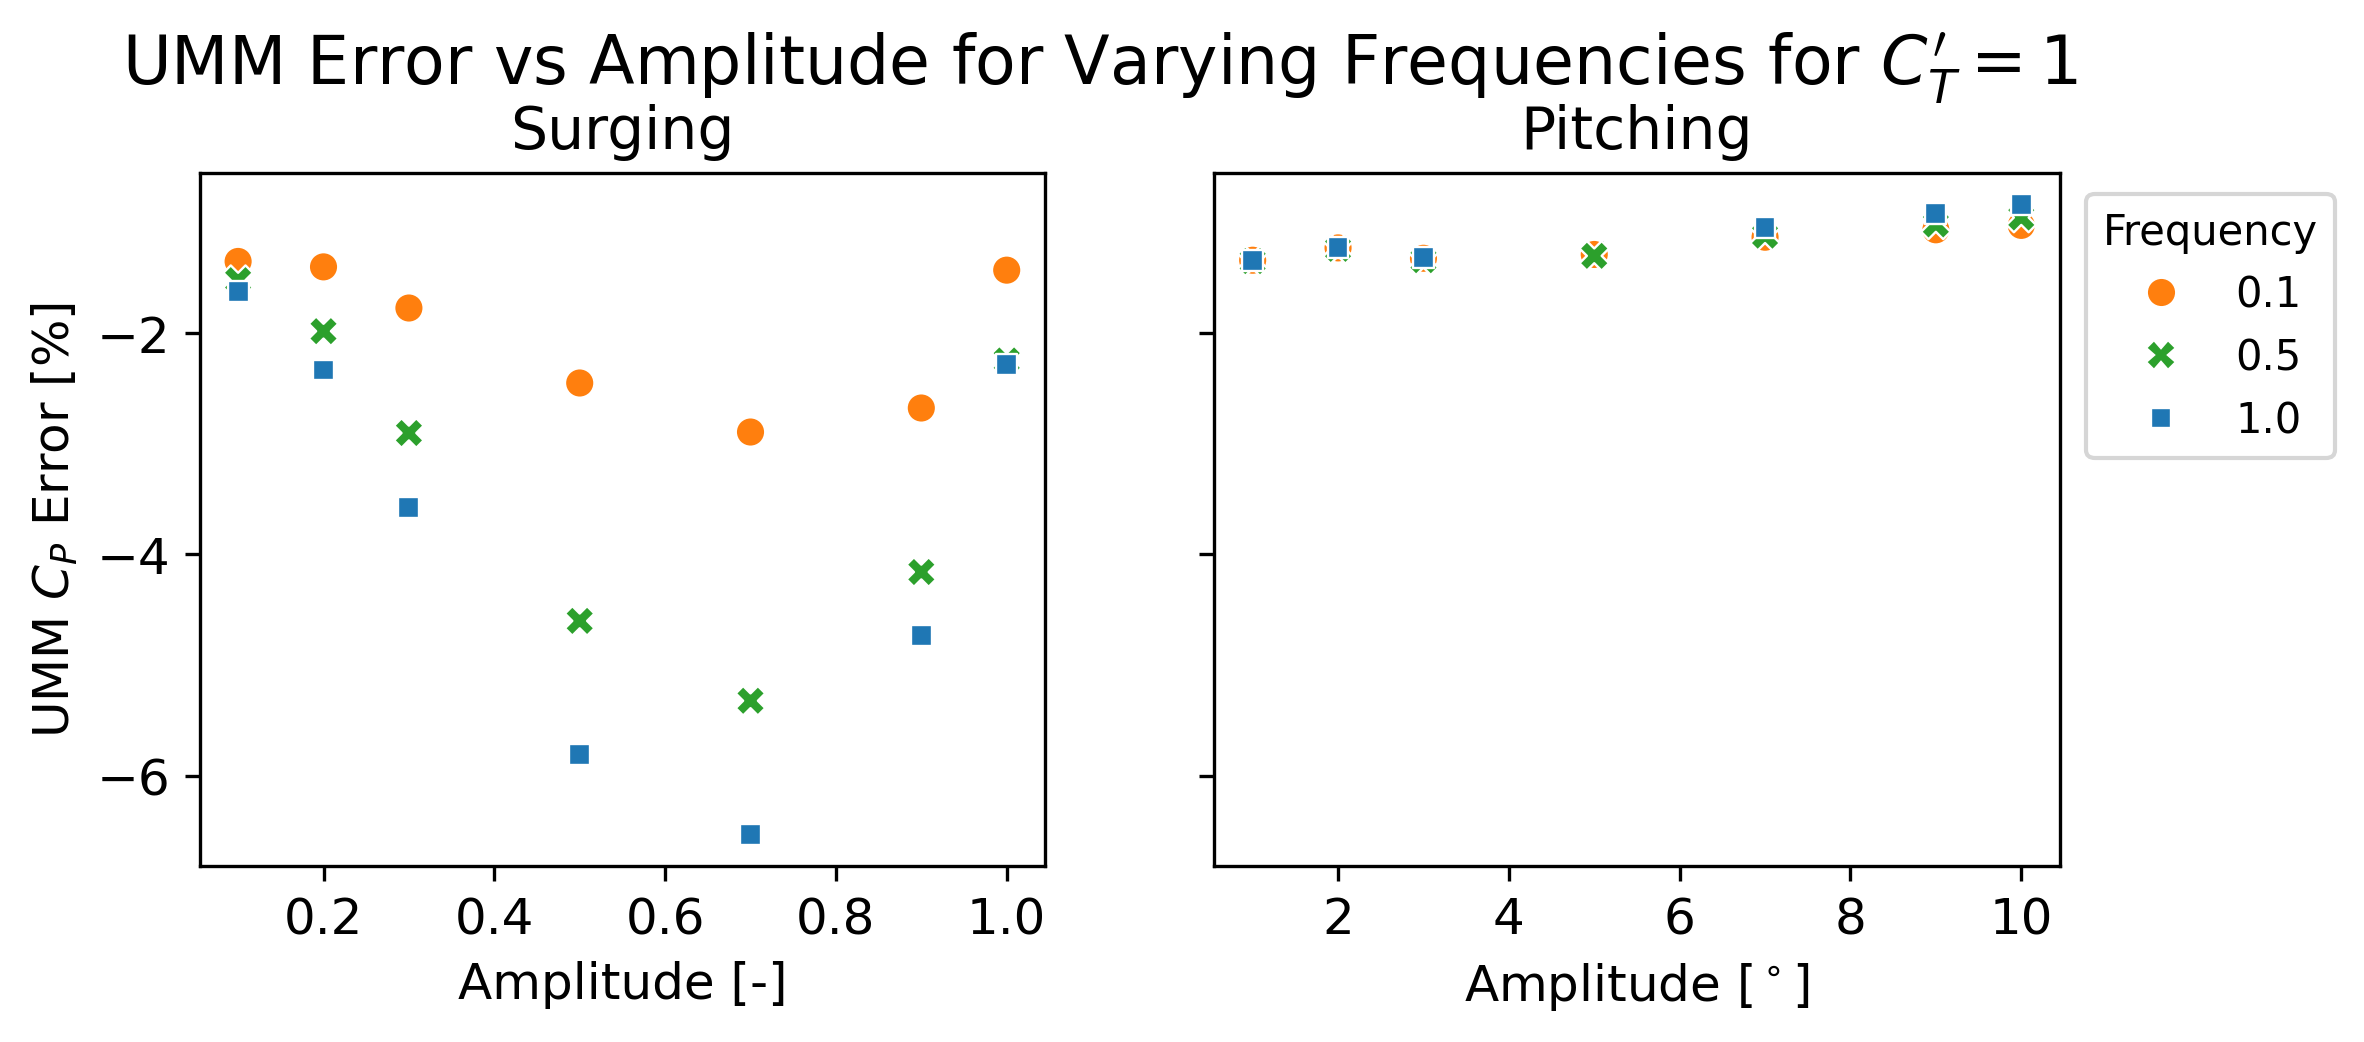

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (8, 3), dpi = 300)
fig.suptitle("UMM Error vs Amplitude for Varying Frequencies for $C_T' = 1$", size = 16, y = 1.04)
ax0.set_title("Surging", size = 14)
ax1.set_title("Pitching", size = 14)
ax0.set_xlabel('Amplitude [-]', size = 12)
ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
ax0.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax1.set_ylabel(' ', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df["Movement"] == "Surging") & (df["CT_prime"] == 1)]
ax1_data = df[(df["Movement"] == "Pitching") & (df["CT_prime"] == 1)]
sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)

fix_plot_legend(ax0, xOffset = 1.55, title = "Frequency")
fig.subplots_adjust(hspace = 0.5)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/3190431624.py:15: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax2, data = ax2_data, x = "surge_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_21664/3190431624.py:16: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax3, data = ax3_data, x = "pitch_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)


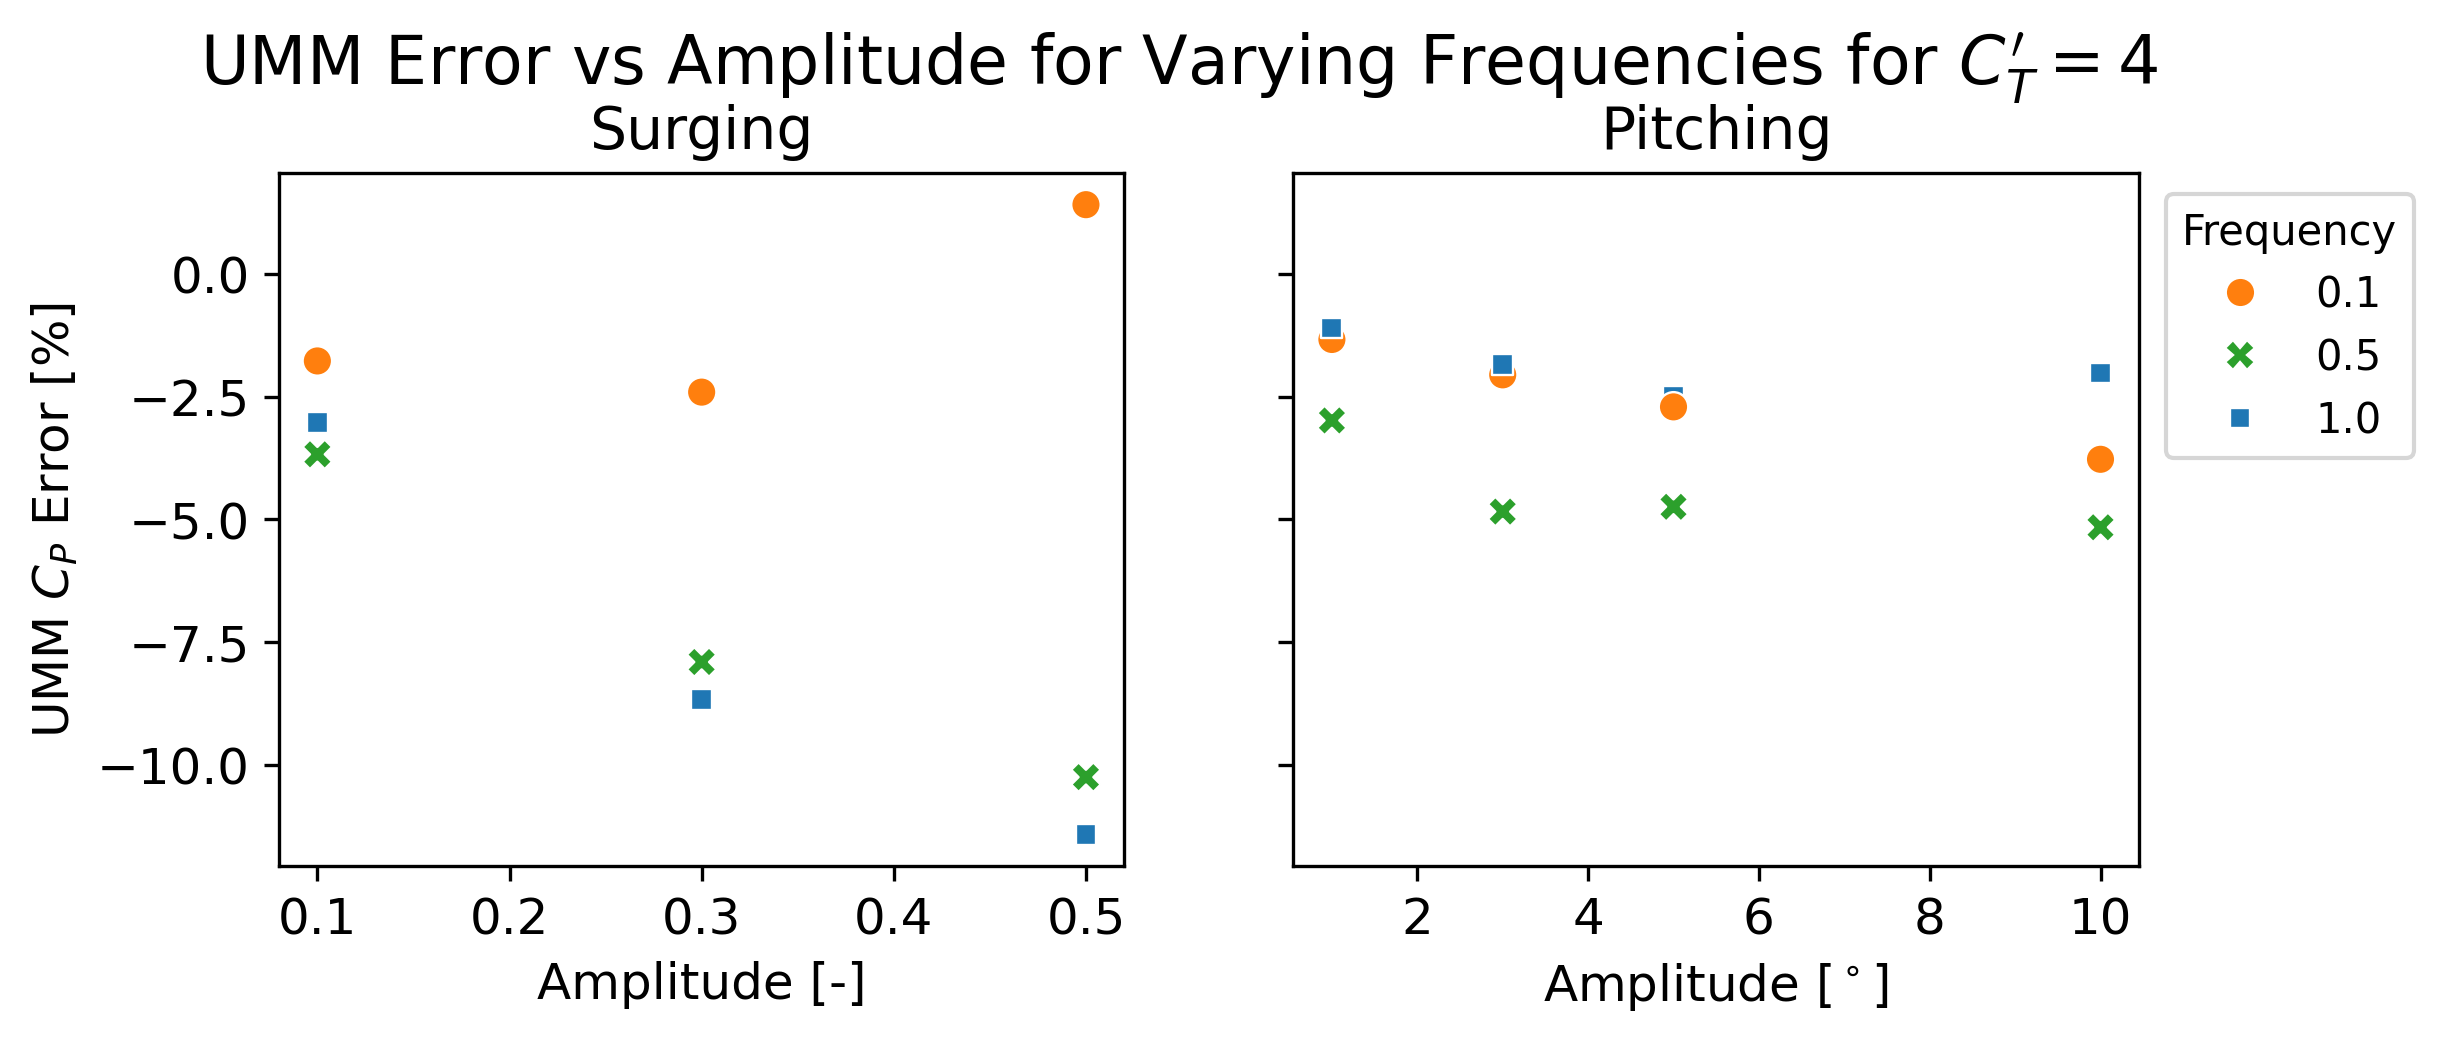

In [19]:
fig, (ax2, ax3) = plt.subplots(1, 2, sharey = True, figsize = (8, 3), dpi = 300)
fig.suptitle("UMM Error vs Amplitude for Varying Frequencies for $C_T' = 4$", size = 16, y = 1.04)

ax2.set_title("Surging", size = 14)
ax3.set_title("Pitching", size = 14)
ax2.set_xlabel('Amplitude [-]', size = 12)
ax3.set_xlabel('Amplitude [$^\circ$]', size = 12)
ax2.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax3.set_ylabel(' ', size = 12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

ax2_data = df[(df["Movement"] == "Surging") & (df["CT_prime"] == 4)]
ax3_data = df[(df["Movement"] == "Pitching") & (df["CT_prime"] == 4)]
sns.scatterplot(ax = ax2, data = ax2_data, x = "surge_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
sns.scatterplot(ax = ax3, data = ax3_data, x = "pitch_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)

fix_plot_legend(ax2, xOffset = 1.55, title = "Frequency")
fig.subplots_adjust(hspace = 0.5)